In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm
from timm.models.vision_transformer import VisionTransformer
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
from tqdm import tqdm

In [2]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
class KvasirDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', train_ratio=0.7, val_ratio=0.15):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        
        # Get all class folders from the image
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        # Get all image paths and their labels
        self.image_paths = []
        self.labels = []
        
        # Process each class folder
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            # Get all images in this class folder
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(class_idx)
        
        # Create deterministic splits based on the file names
        # (using hash to distribute consistently but randomly)
        temp_data = list(zip(self.image_paths, self.labels))
        
        # Sort by image path hash to ensure consistent splits between runs
        temp_data.sort(key=lambda x: hash(os.path.basename(x[0])))
        
        # Split the data
        total_size = len(temp_data)
        train_size = int(train_ratio * total_size)
        val_size = int(val_ratio * total_size)
        
        if split == 'train':
            temp_data = temp_data[:train_size]
        elif split == 'val':
            temp_data = temp_data[train_size:train_size + val_size]
        else:  # 'test'
            temp_data = temp_data[train_size + val_size:]
            
        # Unzip the filtered data
        if temp_data:
            self.image_paths, self.labels = zip(*temp_data)
        else:
            self.image_paths, self.labels = [], []
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def load_kvasir_data(data_root, batch_size=16, num_workers=4):
    # Data augmentation and normalization
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets for each split
    train_dataset = KvasirDataset(root_dir=data_root, transform=transform_train, split='train')
    val_dataset = KvasirDataset(root_dir=data_root, transform=transform_test, split='val')
    test_dataset = KvasirDataset(root_dir=data_root, transform=transform_test, split='test')
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    print(f"Dataset loaded: {len(train_dataset)} training images, {len(val_dataset)} validation images, {len(test_dataset)} test images")
    print(f"Classes: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader, train_dataset.classes

In [4]:
class AdaptiveAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0., policy_dim=64):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # Policy network to decide which tokens to keep
        self.policy_net = nn.Sequential(
            nn.Linear(dim, policy_dim),
            nn.ReLU(),
            nn.Linear(policy_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        B, N, C = x.shape
        
        # Generate policy scores for each token (except CLS token)
        policy_scores = self.policy_net(x[:, 1:]).squeeze(-1)  # [B, N-1]
        
        # Determine how many tokens to keep based on a threshold
        threshold = 0.5  # You can tune this parameter
        k = (policy_scores > threshold).sum(dim=1).int() + 1  # +1 for CLS token
        
        # Ensure k is not too large and has at least 1 token (plus CLS)
        k = torch.clamp(k, min=2, max=N-1)
        max_k = max(k).item()
        
        # Process QKV for all tokens initially
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k_tensor, v = qkv[0], qkv[1], qkv[2]  # Renamed k to k_tensor to avoid variable name conflict
        
        # Calculate full attention scores
        attn = (q @ k_tensor.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        # Apply attention and project back
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        # Create a mask for adaptive token selection
        # Sort tokens by importance (excluding CLS token)
        _, indices = torch.topk(policy_scores, min(N-1, max_k), dim=1)
        mask = torch.zeros_like(policy_scores, dtype=torch.bool)
        
        # Select top-k tokens for each item in batch
        for i in range(B):
            k_val = int(k[i].item()) - 1  # -1 because we already keep CLS token
            if k_val > 0:  # Safety check
                k_val = min(k_val, indices.size(1))  # Ensure we don't exceed indices size
                mask[i, indices[i, :k_val]] = True
        
        # Always keep CLS token and selective tokens based on policy
        keep_mask = torch.cat([torch.ones(B, 1, device=x.device, dtype=torch.bool), mask], dim=1)
        
        return x, keep_mask, k

class AdaViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=8, embed_dim=768, 
                 depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True, drop_rate=0.1, 
                 attn_drop_rate=0.1, drop_path_rate=0.1):
        super().__init__()
        
        # Original ViT components
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)
        
        # Adaptive Transformer Blocks
        self.blocks = nn.ModuleList([
            AdaptiveBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=drop_path_rate
            )
            for i in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
            
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        
        # Add position embeddings
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Track token sparsity and compute ops
        token_counts = []
        original_tokens = x.shape[1]
        
        # Forward through adaptive blocks
        for block in self.blocks:
            x, token_ratio = block(x)
            curr_tokens = x.shape[1]
            token_counts.append(curr_tokens / original_tokens)
        
        x = self.norm(x)
        return x[:, 0], torch.tensor(token_counts)
    
    def forward(self, x):
        x, token_counts = self.forward_features(x)
        x = self.head(x)
        return x, token_counts

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size}*{self.img_size})"
        
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class AdaptiveBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = AdaptiveAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)
        
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        
    def forward(self, x):
        # Adaptive attention with token selection
        attn_out, keep_mask, token_count = self.attn(self.norm1(x))
        x = x + self.drop_path(attn_out)
        
        # Filter tokens based on keep_mask
        x_filtered = x[keep_mask].view(x.shape[0], -1, x.shape[2]) if keep_mask.shape[1] < x.shape[1] else x
        
        # MLP on selected tokens
        x_filtered = x_filtered + self.drop_path(self.mlp(self.norm2(x_filtered)))
        
        # Calculate token ratio (for analysis/monitoring)
        token_ratio = token_count.float().mean() / x.shape[1]
        
        return x_filtered, token_ratio

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.):
        super().__init__()
        self.drop_prob = drop_prob
        
    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        output = x.div(keep_prob) * random_tensor
        return output


In [5]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, checkpoint_path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(model)
            self.counter = 0
            
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.checkpoint_path)
        print(f'Validation loss decreased. Saving model to {self.checkpoint_path}')

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=10, device='cuda', model_dir='./models',
                patience=3, checkpoint_path='adavit_checkpoint.pt'):
    
    # Create model directory if it doesn't exist
    os.makedirs(model_dir, exist_ok=True)
    
    # Full checkpoint path
    full_checkpoint_path = os.path.join(model_dir, checkpoint_path)
    best_model_path = os.path.join(model_dir, 'best_adavit_kvasir.pth')
    final_model_path = os.path.join(model_dir, 'final_adavit_kvasir.pth')
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience, checkpoint_path=full_checkpoint_path)
    
    model.to(device)
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    token_sparsity = []
    
    # For timing
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        epoch_token_ratios = []
        
        # Use tqdm for progress bar
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs, token_counts = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Track token sparsity
            epoch_token_ratios.append(token_counts.mean().item())
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': loss.item(),
                'acc': correct / total,
                'token_ratio': token_counts.mean().item()
            })
        
        epoch_loss = running_loss / total
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        token_sparsity.append(sum(epoch_token_ratios) / len(epoch_token_ratios))
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Use tqdm for progress bar
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]')
        
        with torch.no_grad():
            for inputs, labels in val_pbar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_pbar.set_postfix({
                    'loss': loss.item(),
                    'acc': val_correct / val_total
                })
        
        val_epoch_loss = val_loss / val_total
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accs.append(val_epoch_acc)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model based on accuracy
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved with accuracy: {best_val_acc:.4f}')
        
        # Apply early stopping
        early_stopping(val_epoch_loss, model)
        
        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time
        eta = epoch_time * (num_epochs - epoch - 1)
        
        print(f'Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s (ETA: {eta/60:.2f}m)')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        print(f'Token Ratio: {token_sparsity[-1]:.4f}')
        
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Save final model regardless of performance
    torch.save(model.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    # Load best model
    model.load_state_dict(torch.load(best_model_path))
    
    # Total training time
    total_time = time.time() - start_time
    print(f"Total training time: {total_time/60:.2f} minutes")
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'token_sparsity': token_sparsity,
        'training_time': total_time
    }


In [7]:
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    all_preds = []
    all_labels = []
    
    # Use tqdm for progress bar
    test_pbar = tqdm(test_loader, desc='Evaluating')
    
    with torch.no_grad():
        for inputs, labels in test_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes, output_dict=True)
    
    return cm, report

def plot_results(history, cm, report, classes, save_dir='./results'):
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Plot training history
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(history['train_accs'], label='Train Acc')
    plt.plot(history['val_accs'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 3, 3)
    plt.plot(history['token_sparsity'], marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Token Ratio')
    plt.title('Token Sparsity (lower is more efficient)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'adavit_training_history.png'))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'adavit_confusion_matrix.png'))
    
    # Plot class-wise performance
    plt.figure(figsize=(12, 6))
    metrics = ['precision', 'recall', 'f1-score']
    for i, metric in enumerate(metrics):
        values = [report[cls][metric] for cls in classes]
        plt.subplot(1, 3, i+1)
        plt.bar(classes, values)
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.title(f'Class-wise {metric.capitalize()}')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'adavit_class_performance.png'))


Dataset loaded: 5600 training images, 1200 validation images, 1200 test images
Classes: ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
Model initialized: AdaViT with 86,396,180 trainable parameters
Using device: cuda
Starting training...


Epoch 1/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:28<00:00,  2.62it/s, loss=0.603, acc=0.584]


New best model saved with accuracy: 0.5842
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 1/20 completed in 222.57s (ETA: 70.48m)
Train Loss: 1.0473, Train Acc: 0.5304
Val Loss: 0.8745, Val Acc: 0.5842
Token Ratio: 1.0000


Epoch 2/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.34it/s, loss=0.501, acc=0.618]


New best model saved with accuracy: 0.6183
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 2/20 completed in 201.63s (ETA: 60.49m)
Train Loss: 0.9001, Train Acc: 0.5707
Val Loss: 0.7874, Val Acc: 0.6183
Token Ratio: 1.0000


Epoch 3/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.35it/s, loss=0.577, acc=0.616]


Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 3/20 completed in 193.43s (ETA: 54.81m)
Train Loss: 0.8298, Train Acc: 0.5980
Val Loss: 0.7464, Val Acc: 0.6158
Token Ratio: 1.0000


Epoch 4/20 [Valid]: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.28it/s, loss=0.48, acc=0.646]


New best model saved with accuracy: 0.6458
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 4/20 completed in 199.93s (ETA: 53.32m)
Train Loss: 0.7825, Train Acc: 0.6218
Val Loss: 0.7091, Val Acc: 0.6458
Token Ratio: 1.0000


Epoch 5/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.29it/s, loss=0.475, acc=0.618]


EarlyStopping counter: 1 out of 3
Epoch 5/20 completed in 194.83s (ETA: 48.71m)
Train Loss: 0.7526, Train Acc: 0.6302
Val Loss: 0.7784, Val Acc: 0.6175
Token Ratio: 1.0000


Epoch 6/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.28it/s, loss=0.468, acc=0.697]


New best model saved with accuracy: 0.6967
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 6/20 completed in 195.89s (ETA: 45.71m)
Train Loss: 0.7099, Train Acc: 0.6534
Val Loss: 0.6377, Val Acc: 0.6967
Token Ratio: 1.0000


Epoch 7/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.27it/s, loss=0.607, acc=0.707]


New best model saved with accuracy: 0.7067
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 7/20 completed in 196.76s (ETA: 42.63m)
Train Loss: 0.6867, Train Acc: 0.6702
Val Loss: 0.6333, Val Acc: 0.7067
Token Ratio: 1.0000


Epoch 8/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.27it/s, loss=0.561, acc=0.721]


New best model saved with accuracy: 0.7208
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 8/20 completed in 195.44s (ETA: 39.09m)
Train Loss: 0.6475, Train Acc: 0.6866
Val Loss: 0.5917, Val Acc: 0.7208
Token Ratio: 1.0000


Epoch 9/20 [Valid]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.28it/s, loss=0.644, acc=0.732]


New best model saved with accuracy: 0.7317
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 9/20 completed in 195.55s (ETA: 35.85m)
Train Loss: 0.6263, Train Acc: 0.7011
Val Loss: 0.5801, Val Acc: 0.7317
Token Ratio: 1.0000


Epoch 10/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:22<00:00,  3.28it/s, loss=0.579, acc=0.747]


New best model saved with accuracy: 0.7467
Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 10/20 completed in 195.24s (ETA: 32.54m)
Train Loss: 0.6026, Train Acc: 0.7163
Val Loss: 0.5639, Val Acc: 0.7467
Token Ratio: 1.0000


Epoch 11/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:21<00:00,  3.45it/s, loss=0.579, acc=0.747]


Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 11/20 completed in 188.02s (ETA: 28.20m)
Train Loss: 0.6026, Train Acc: 0.7130
Val Loss: 0.5639, Val Acc: 0.7467
Token Ratio: 1.0000


Epoch 12/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:35<00:00,  2.13it/s, loss=0.589, acc=0.741]


Validation loss decreased. Saving model to ./models\adavit_checkpoint.pt
Epoch 12/20 completed in 216.40s (ETA: 28.85m)
Train Loss: 0.6078, Train Acc: 0.7137
Val Loss: 0.5635, Val Acc: 0.7408
Token Ratio: 1.0000


Epoch 13/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:21<00:00,  3.43it/s, loss=0.585, acc=0.734]


EarlyStopping counter: 1 out of 3
Epoch 13/20 completed in 196.90s (ETA: 22.97m)
Train Loss: 0.6138, Train Acc: 0.7014
Val Loss: 0.5770, Val Acc: 0.7342
Token Ratio: 1.0000


Epoch 14/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:21<00:00,  3.44it/s, loss=0.566, acc=0.703]


EarlyStopping counter: 2 out of 3
Epoch 14/20 completed in 187.90s (ETA: 18.79m)
Train Loss: 0.6344, Train Acc: 0.7002
Val Loss: 0.6400, Val Acc: 0.7025
Token Ratio: 1.0000


Epoch 15/20 [Valid]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:21<00:00,  3.41it/s, loss=0.507, acc=0.744]


EarlyStopping counter: 3 out of 3
Epoch 15/20 completed in 185.34s (ETA: 15.45m)
Train Loss: 0.6520, Train Acc: 0.6927
Val Loss: 0.5777, Val Acc: 0.7442
Token Ratio: 1.0000
Early stopping triggered!
Final model saved to ./models\final_adavit_kvasir.pth


C:\Users\ninja\AppData\Local\Temp\ipykernel_26864\2968081192.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Total training time: 49.51 minutes
Evaluating model...


Evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75/75 [00:21<00:00,  3.42it/s]


Creating visualizations...

Training and evaluation complete!
Best validation accuracy: 0.7467
Final token sparsity: 1.0000 (lower means more efficient)
Total training time: 49.51 minutes

Class-wise performance:
dyed-lifted-polyps: F1-score = 0.6806
dyed-resection-margins: F1-score = 0.6983
esophagitis: F1-score = 0.7239
normal-cecum: F1-score = 0.8524
normal-pylorus: F1-score = 0.9398
normal-z-line: F1-score = 0.7799
polyps: F1-score = 0.6000
ulcerative-colitis: F1-score = 0.6997

Model saved at:
  - Best model: ./models/best_adavit_kvasir.pth
  - Final model: ./models/final_adavit_kvasir.pth
  - Checkpoint: ./models/adavit_checkpoint.pt

Results saved at:
  - Training history: ./results/adavit_training_history.png
  - Confusion matrix: ./results/adavit_confusion_matrix.png
  - Class performance: ./results/adavit_class_performance.png


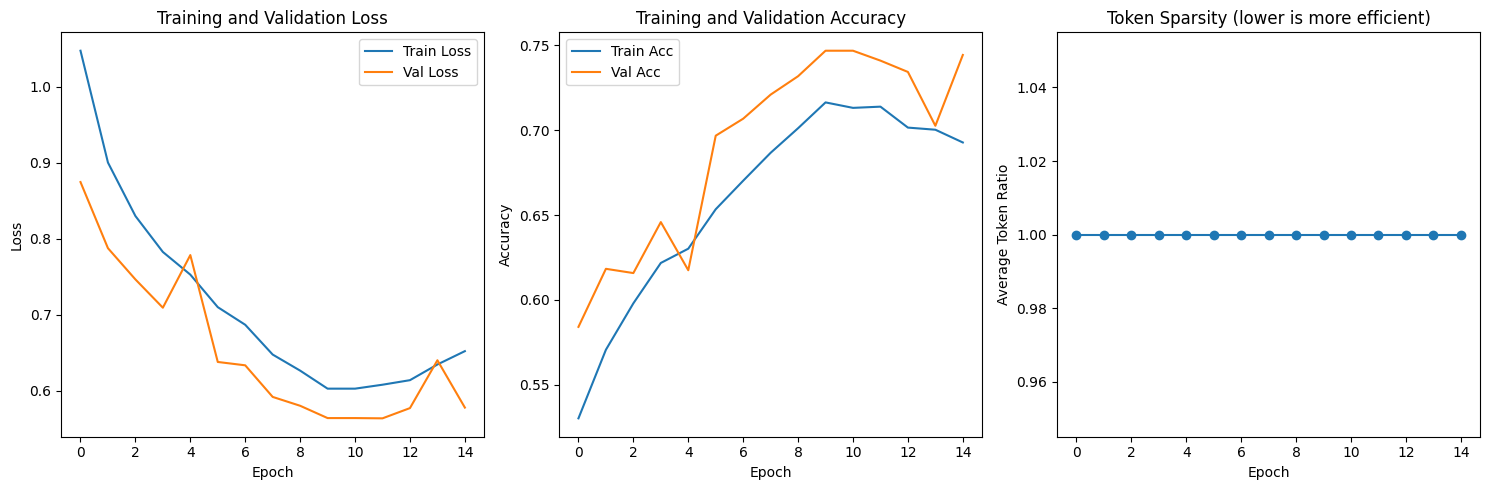

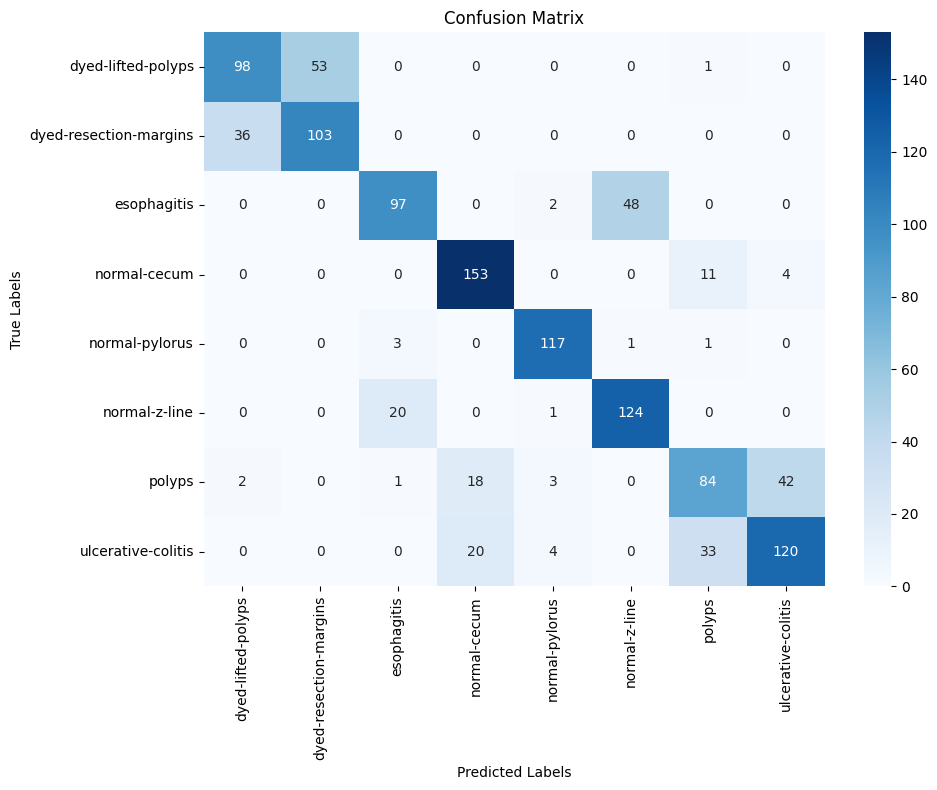

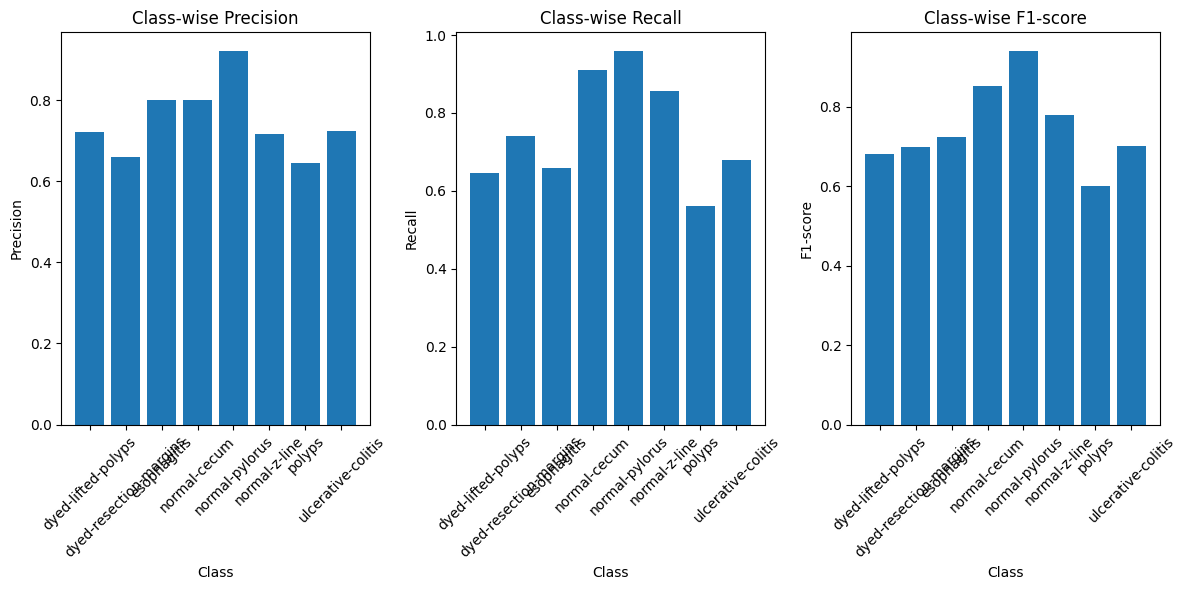

In [8]:
def main():
    # Path to the final model
    model_path = './models/final_adavit_kvasir.pth'
    
    # Create directories for saving models and results
    os.makedirs('./models', exist_ok=True)
    os.makedirs('./results', exist_ok=True)
    
    # Load the Kvasir dataset using the new loader
    train_loader, val_loader, test_loader, classes = load_kvasir_data(
        data_root=r"G:\USER\Documents\GitHub\Masters-Project\Datasets\kvasir-dataset-v2",  
        batch_size=16,
        num_workers=0
    )
    
    # Check if model file exists
    if os.path.exists(model_path):
        print(f"Found existing model at {model_path}. Loading model...")
        
        # Initialize model with the same configuration as during training
        model = AdaViT(
            img_size=224,
            patch_size=16,
            in_chans=3,
            num_classes=len(classes),
            embed_dim=768,
            depth=12,
            num_heads=12,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.1
        )
        
        # Load the model weights
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(model_path, map_location=device))
        model = model.to(device)
        
        print("Model loaded successfully.")
        
        # Evaluation
        print("Evaluating model...")
        cm, report = evaluate_model(model, val_loader, device)
        
        # Plot results (you might want to modify this if you don't have a previous history)
        history = {
            'val_accs': [0],  # Placeholder values
            'token_sparsity': [0],
            'training_time': 0
        }
        
        # Plot results
        print("Creating visualizations...")
        plot_results(history, cm, report, classes, save_dir='./results')
        
        print("\nModel evaluation complete!")
    else:
        # Original training code
        # Initialize model
        model = AdaViT(
            img_size=224,
            patch_size=16,
            in_chans=3,
            num_classes=len(classes),
            embed_dim=768,
            depth=12,
            num_heads=12,
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_rate=0.1
        )
        
        # Print model summary
        print(f"Model initialized: AdaViT with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        
        # Training
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        print("Starting training...")
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=20,
            device=device,
            model_dir='./models',
            patience=3  
        )
        
        # Evaluation
        print("Evaluating model...")
        cm, report = evaluate_model(model, val_loader, device)
        
        # Plot results
        print("Creating visualizations...")
        plot_results(history, cm, report, classes, save_dir='./results')
        
        print("\nTraining and evaluation complete!")
        print(f"Best validation accuracy: {max(history['val_accs']):.4f}")
        print(f"Final token sparsity: {history['token_sparsity'][-1]:.4f} (lower means more efficient)")
        print(f"Total training time: {history['training_time']/60:.2f} minutes")
    
    # Print common output
    print("\nClass-wise performance:")
    for cls in classes:
        print(f"{cls}: F1-score = {report[cls]['f1-score']:.4f}")
    
    print("\nModel saved at:")
    print(f"  - Best model: ./models/best_adavit_kvasir.pth")
    print(f"  - Final model: ./models/final_adavit_kvasir.pth")
    print(f"  - Checkpoint: ./models/adavit_checkpoint.pt")
    
    print("\nResults saved at:")
    print(f"  - Training history: ./results/adavit_training_history.png")
    print(f"  - Confusion matrix: ./results/adavit_confusion_matrix.png")
    print(f"  - Class performance: ./results/adavit_class_performance.png")

if __name__ == "__main__":
    main()